# GAN - Generative Adversial Networks

Composed of two networks: Discriminator and Generator.

Discriminator classify whether image is real or generated by the generator.
Generator generates images which should be so good to cheat discriminator

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# plotting MNIST image
def plot(image):
    plt.axis('off')
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.show()
    
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

# Print the shapes of images from each subset
print ("IMAGES:")
print (mnist.test.images.shape)
print (mnist.train.images.shape)
print (mnist.validation.images.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
IMAGES:
(10000, 784)
(55000, 784)
(5000, 784)


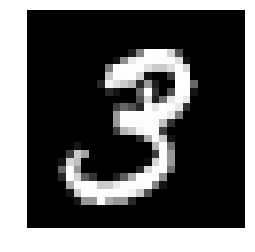

In [5]:
plot(mnist.train.images[1])

In [6]:
print(mnist.train.images[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [7]:
def get_weight_variable(shape):
    # normal distribution with mean = 0, standard deviation = 0.02
    init = tf.random_normal(shape, stddev=0.02)
    return tf.Variable(init)    

# Discriminator
1. First convolutional layer -> maps to one gray scale image to 16 feature maps
2. Second convolutional layer -> maps 16 features to 64 features maps
3. Third convolutional layer -> maps 64 features to 256 features maps
4. Fully connected layer -> maps 256 features into output layer with 2 classes (real and generated images)

Using stride in size 2 in width and height directions (divide images size by 4)

In [8]:
# matrix W and biased vector b used for first convolutional layer -> 16 filters, 5 x 5 x 1 size
d_W1 = get_weight_variable([5, 5, 1, 16])
d_b1 = get_weight_variable([16])

# matrix W and biased vector b used for second convolutional layer -> 64 filters, 5 x 5 x 16 size
d_W2 = get_weight_variable([5, 5, 16, 64])
d_b2 = get_weight_variable([64])

# matrix W and biased vector b used for third convolutional layer -> 256 filters, 5 x 5 x 64 size
d_W3 = get_weight_variable([5, 5, 64, 256])
d_b3 = get_weight_variable([256])

# matrix W and biased vector b used by th e output fully convolutional layer -> from 4096 features to 2 classes
d_W4 = get_weight_variable([4096, 1]) # from 4096 features to 1 feature
d_b4 = get_weight_variable([1])

In [9]:
def discriminator(x):
    # create first layer - use stride 2 in width/height, padding = 'SAME', activated by ReLU fun
    x = tf.nn.conv2d(x, d_W1, [1, 2, 2, 1], padding='SAME') # [batch_size, 14, 14, 16]
    x = tf.nn.relu(x + d_b1)
    
    # create second layer - use stride 2 in width/height, padding = 'SAME', activated by ReLU fun
    x = tf.nn.conv2d(x, d_W2, [1, 2, 2, 1], padding='SAME') # [batch_size, 7, 7, 64]
    x = tf.nn.relu(x + d_b2)
    
    # create third layer - use stride 2 in width/height, padding = 'SAME', activated by ReLU fun
    x = tf.nn.conv2d(x, d_W3, [1, 2, 2, 1], padding='SAME') # [batch_size, 4, 4, 256]
    x = tf.nn.relu(x + d_b3)
    
    # reshape input 4*4*256 = 4096 dimensions
    x = tf.reshape(x, [-1, 4*4*256])
    
    # create fully connected layer, multiply x by d_W4 and add bias, this will give logits to discriminator network
    D_logit = tf.matmul(x, d_W4) + d_b4 # from [b_size, 4096] to [b_size, 1]
    
    D_probability = tf.nn.sigmoid(D_logit)
    
    return D_probability, D_logit

# Generator
Create 28 x 28 image from 100D vector from normal distribution using transpoe convolution operation

1. Fully connected layer -> maps initial 100 dimensions into 4096 features (4x4 with 256 channels)
2. First transpose convolutional layer -> maps 4x4x256 images to 7x7 with 64 channels (4096 -> 3136)
3. Second transpose convolutionl layer -> maps 7x7x64 images to 14x14 with 16 channels
4. Third transpose convolutional layer -> maps 14x14x16 images to 28x28 with 1 channel (grayscale)

In [10]:
# matrix W and biased vector b used for input fully connected layer -> 100 random features into 4096D (4x4x256 image)
g_W1 = get_weight_variable([100, 4096])
g_b1 = get_weight_variable([4096])

# matrix W and biased vector b used for first transpose convolutional layer -> 64 transpose_conv filter with 5x5x256
g_W2 = get_weight_variable([5, 5, 64, 256])
g_b2 = get_weight_variable([64])

# matrix W and biased vector b used for input fully connected layer -> 16 transpose_conv filter with 5x5x64
g_W3 = get_weight_variable([5, 5, 16, 64])
g_b3 = get_weight_variable([16])

# matrix W and biased vector b used for input fully connected layer -> 1 transpose_conv filter with 5x5x16
g_W4 = get_weight_variable([5, 5, 1, 16])
g_b4 = get_weight_variable([1])

In [11]:
def generator(z):
    
    # fully-con layer [b_size, 100] -> [b_size, 4096]
    z = tf.matmul(z, g_W1) + g_b1
    z = tf.nn.relu(z)
    z = tf.nn.dropout(z, generator_prob_keeper)
    z = tf.reshape(z, [-1, 4, 4, 256]) # reshape [b_size, 4096] -> [b_size, 4, 4, 256]
    
    # first transpose convolutional layer
    # enlarge image 4x4x256 -> 7x7x64, use stride 2 width/height
    # apply convolution, ReLU and dropout with generator_prob_keeper probability
    z = tf.nn.conv2d_transpose(z, g_W2, [batch_size, 7, 7, 64], [1, 2, 2, 1], padding='SAME')
    z = tf.nn.relu(z + g_b2)
    z = tf.nn.dropout(z, generator_prob_keeper)
    
    # second transpose convolutional layer
    # enlarge image 7x7x64 -> 14x14x16, use stride 2 width/height
    # apply convolution, ReLU and dropout with generator_prob_keeper probability
    z = tf.nn.conv2d_transpose(z, g_W3, [batch_size, 14, 14, 16], [1, 2, 2, 1], padding='SAME')
    z = tf.nn.relu(z + g_b3)
    z = tf.nn.dropout(z, generator_prob_keeper)
    
    # third transpose convolutional layer
    # enlarge image 14x14x16 -> 28x28x1, use stride 2 width/height
    # apply convolution, ReLU and dropout with generator_prob_keeper probability
    z = tf.nn.conv2d_transpose(z, g_W4, [batch_size, 28, 28, 1], [1, 2, 2, 1], padding='SAME')
    
    G_probability = tf.nn.sigmoid(z + g_b4)
    
    return G_probability

In [12]:
def sampling_Z(m1, m2):
    return np.random.normal(size=[m1, m2], scale=1)

In [13]:
#Constants
batch_size = 64
Z_dimension = 100 # size of initialized vector (dimension)

# Discriminator
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

#Generator
Z = tf.placeholder(tf.float32, shape=[None, 100])
generator_prob_keeper = 0.9 #probability of dropout

In [14]:
Generator_sample = generator(Z)

D_real, D_logit_real = discriminator(X)

D_fake, D_logit_fake = discriminator(Generator_sample)

In [15]:
ep = 1e-5

D_loss_real = tf.reduce_mean(-tf.log(D_real + ep)) # loss on real examples

D_loss_fake = tf.reduce_mean(-tf.log(1 - D_fake + ep)) # loss on fake examples

D_loss = D_loss_real + D_loss_fake

# create AdamOptimizer to minimalize cross_entropy loss function
var_list_d = [d_W1, d_b1, d_W2, d_b2, d_W3, d_b3, d_W4, d_b4]

D_solver = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(D_loss, var_list=var_list_d)


In [ ]:
G_loss = tf.reduce_mean(-tf.log(D_fake + ep))

var_list_g = [g_W1, g_b1, g_W2, g_b2, g_W3, g_b3, g_W4, g_b4]

G_solver = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(G_loss, var_list=var_list_g)

1 Epoch: 0.0013333333333333333
G_loss: 0.0009368
D_loss: 0.001844


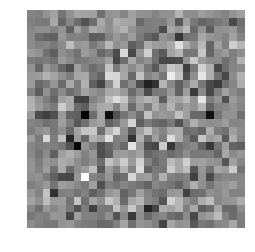

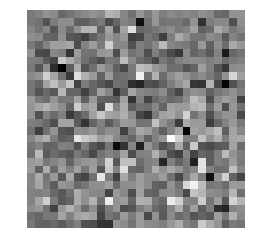

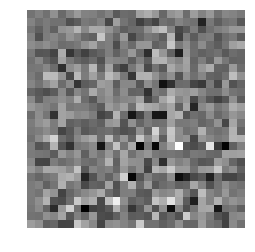

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 27

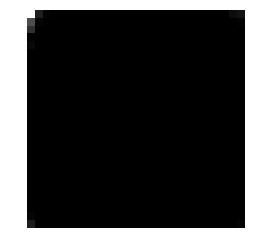

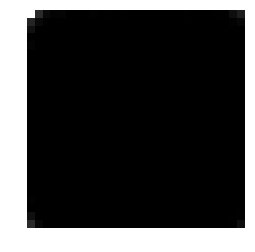

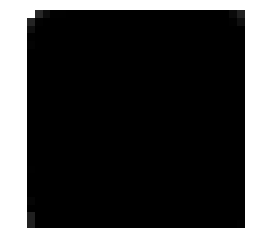

752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 100

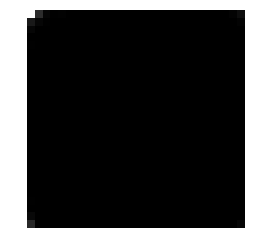

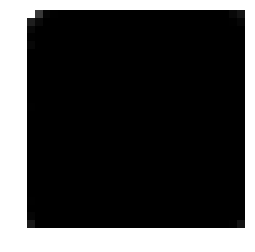

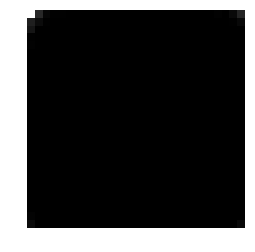

1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 

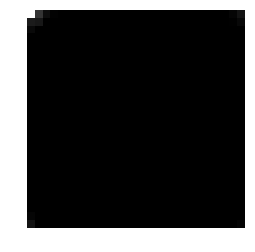

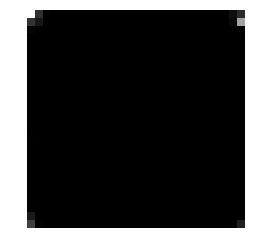

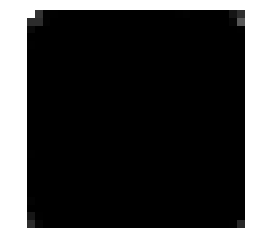

2252 2253 2254 2255 2256 2257 2258 2259 2260 2261 2262 2263 2264 2265 2266 2267 2268 2269 2270 2271 2272 2273 2274 2275 2276 2277 2278 2279 2280 2281 2282 2283 2284 2285 2286 2287 2288 2289 2290 2291 2292 2293 2294 2295 2296 2297 2298 2299 2300 2301 2302 2303 2304 2305 2306 2307 2308 2309 2310 2311 2312 2313 2314 2315 2316 2317 2318 2319 2320 2321 2322 2323 2324 2325 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2361 2362 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376 2377 2378 2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446 2447 2448 2449 2450 2451 

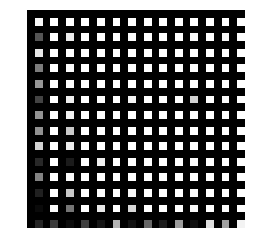

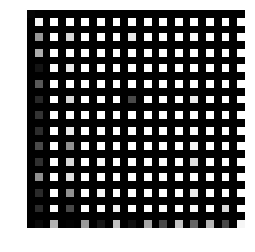

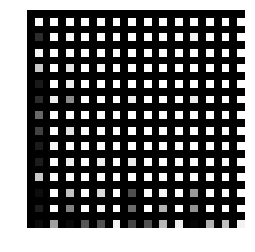

3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201 

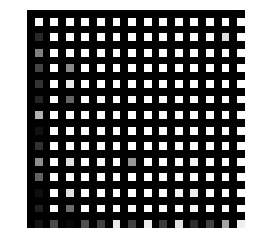

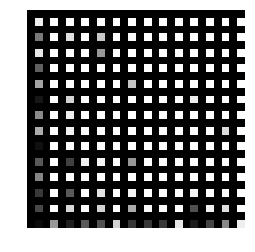

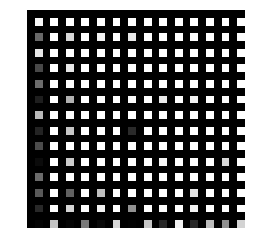

3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762 3763 3764 3765 3766 3767 3768 3769 

KeyboardInterrupt: 

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for i in range(1, 20000):
        print(i, end=" ")
        images_set = mnist.train.next_batch(batch_size)[0].reshape(-1, 28, 28, 1)
            
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: images_set, Z: sampling_Z(batch_size, Z_dimension)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sampling_Z(batch_size, Z_dimension)})
        
        G_loss_epoch += G_loss_curr
        D_loss_epoch += D_loss_curr
        
        if i % 750 == 1:
            print('Epoch: {}'.format(i/750))
            print('G_loss: {:.4}'.format(G_loss_epoch/750))
            print('D_loss: {:.4}'.format(D_loss_epoch/750))
                  
            G_loss_epoch = 0
            D_loss_epoch = 0
                  
            samples = sess.run(Generator_sample, feed_dict={Z: sampling_Z(batch_size, Z_dimension)})
            for i in range(3):
                  plot(samples[i])